In [984]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [985]:
dir_path = "~/movielens/ralf"
user_features_path = f"{dir_path}/user_features.csv"
movie_features_path = f"{dir_path}/movie_features.csv"
ratings_path = f"{dir_path}/ratings.csv"

In [986]:
def get_features(file_path):
    df = pd.read_csv(file_path)
    features = dict()
    for row in df.itertuples():
        features[row.id] = np.array(eval(row.features))
    return features 

In [987]:
def get_feature_update(features, row):
    features[row.user_id] = np.array(eval(row.user_features))

In [988]:
user_features = get_features(user_features_path)
movie_features = get_features(movie_features_path)

In [989]:
test_data = pd.read_csv(ratings_path)

In [990]:
experiment_path = "~/experiment_results/100k-massive.2"
feature_updates = pd.read_csv(f"{experiment_path}/results_workers_1_fifo_learningrate_0.02_userfeaturereg_0.01.csv")

In [991]:
len(feature_updates)

49399

In [992]:
feature_updates

,user_id,user_features,timestamp
0,712,"[0.196146516118746, -0.08941406092126292, 0.30...",1
1,712,"[0.18627229363867254, -0.09373003981315085, 0....",1
2,712,"[0.19008081039869745, -0.09094296836129032, 0....",1
3,712,"[0.18530072893609403, -0.09580932104634117, 0....",1
4,712,"[0.18926061817082734, -0.09322372518128175, 0....",1
...,...,...,...
49394,479,"[0.26942851277978613, 0.12764496902208425, 0.2...",494
49395,661,"[0.24565806379718302, 0.06744957218358588, 0.1...",494
49396,683,"[0.2180142020061294, -0.02899228737369761, 0.1...",494
49397,729,"[-0.02097903376569311, -0.13886990660449836, 0...",494


In [993]:
len(test_data[test_data['timestamp'] == 0])

99

In [994]:
len(feature_updates[feature_updates['timestamp'] == 494])

195

In [995]:
len(feature_updates)

49399

In [996]:
max(feature_updates['timestamp'])

494

In [997]:
def predict_rating(user_feature, movie_feature):
    return user_feature.dot(movie_feature.T)

def compute_test_mse(user_features, movie_features):
    predictions = []
    ratings = []
    count = 0
    for row in test_data.itertuples():
        user_id = row.user_id
        movie_id = row.movie_id
        rating = row.rating
        predictions.append(predict_rating(user_features[user_id], movie_features[movie_id]))
        ratings.append(rating) 
    mse = mean_squared_error(ratings, predictions)
    return mse

def compute_mse(user_features):
    predictions = []
    ratings = []
    for row in test_data.itertuples():
        user_id = row.user_id
        movie_id = row.movie_id
        rating = row.rating
        ratings.append(rating)
        predictions.append(predict_rating(user_features[user_id], movie_features[movie_id]))
    return mean_squared_error(ratings, predictions)

def compute_improvement():
    count = 0
    predictions = []
    ratings = []
    max_timestamp = max(feature_updates['timestamp'])
    print(max_timestamp, len(feature_updates), len(test_data))
    baseline = compute_mse(user_features)
    while count <= max_timestamp:
        feature_update_ts = feature_updates[feature_updates['timestamp'] == count] 
        for row in feature_update_ts.itertuples():
            user_features[row.user_id] = np.array(eval(row.user_features))
        query_ts = test_data[test_data['timestamp'] == count]
        for row in query_ts.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            predictions.append(predict_rating(user_features[user_id], movie_features[movie_id]))
            ratings.append(rating)
        count += 1
    new_mse = mean_squared_error(ratings, predictions)
    optimal = compute_mse(user_features)
    return baseline, new_mse, optimal

In [998]:
mse = compute_improvement()
print(mse)

494 49399 49442
(0.9649927556378177, 8.305402745179398, 14.522112134306681)


In [999]:
def plot_learning_curve(mse):
        """visualize the training/testing loss"""
        linewidth = 3
        plt.plot(mse, label = 'Ralf', linewidth = linewidth)
        plt.xlabel('iterations')
        plt.ylabel('MSE')
        plt.legend(loc = 'best')

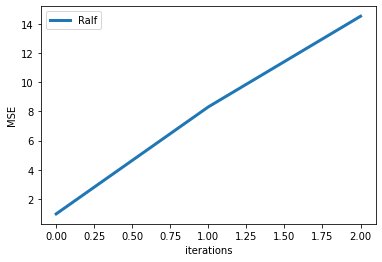

In [1000]:
plot_learning_curve(mse)